# Name- Sharik Gazi


# Tumor Detection using CNN 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

C:\Users\Sharik Gazi\AppData\Local\Temp\ipykernel_13316\3866059657.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

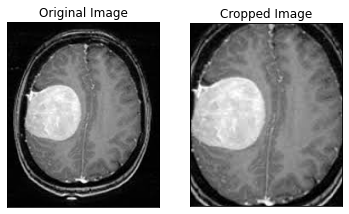

In [5]:
original_img = cv2.imread('train\yes\Y1.jpg')
crop_img = crop_brain_contour(original_img, True)

In [6]:
augmented_path = 'train/'  # augmented_path contains the training samples

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [7]:
import time    

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [8]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='constant', cval=0
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [9]:
start_time = time.time()

augmented_data_path = 'AG/'

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='train/yes/', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='train/no/', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

KeyboardInterrupt: 

In [10]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

# Loading Images from Train Dataset

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


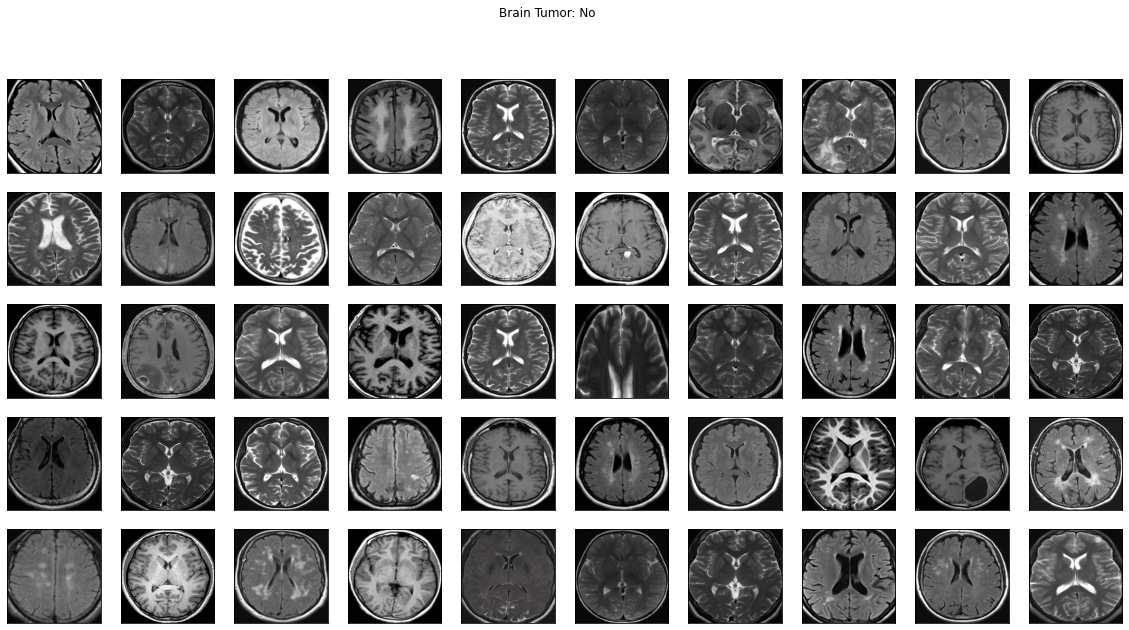

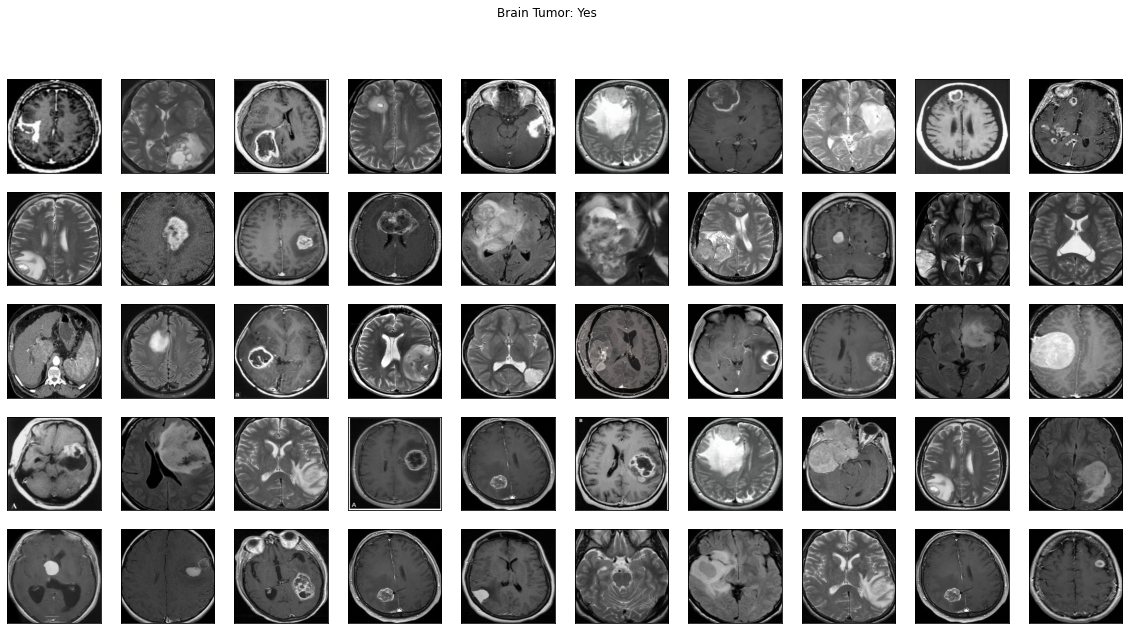

In [11]:
augmented_path = 'train/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X1, y1 = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
plot_sample_images(X1, y1, n=50)

# Loading Images from Augmented(AG) Dataset

Number of examples is: 2248
X shape is: (2248, 240, 240, 3)
y shape is: (2248, 1)


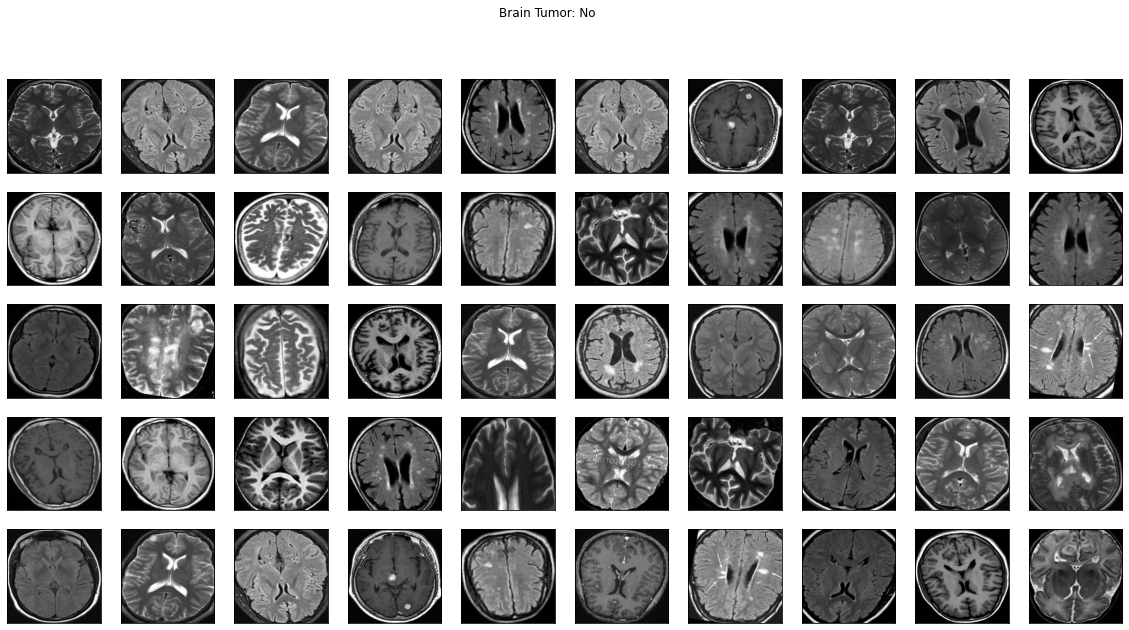

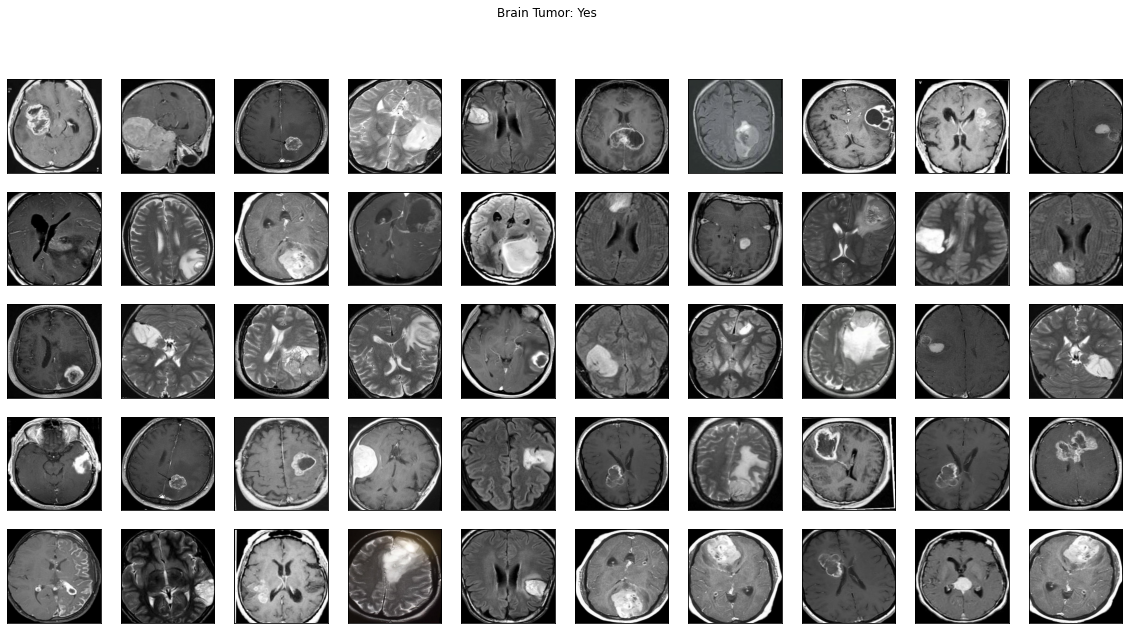

In [12]:
augmented_path = 'AG/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X2, y2 = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
plot_sample_images(X2, y2, n=50)

# Split the data
Split X2 and y2 into training, validation (development) and validation sets.

In [13]:
def split_data(X2, y2, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X2, y2, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test    

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X2, y2, test_size=0.2)

In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1798
number of development examples = 225
number of test examples = 225
X_train shape: (1798, 240, 240, 3)
Y_train shape: (1798, 1)
X_val (dev) shape: (225, 240, 240, 3)
Y_val (dev) shape: (225, 1)
X_test shape: (225, 240, 240, 3)
Y_test shape: (225, 1)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create the AlexNet model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(240, 240, 3)))

# Layer 2: Max Pooling Layer
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))

# Layer 4: Max Pooling Layer
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 5: Convolutional Layer
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Layer 6: Convolutional Layer
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Layer 7: Convolutional Layer
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# Layer 8: Max Pooling Layer
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 9: Flatten Layer
model.add(Flatten())

# Layer 10: Fully-Connected Layer
model.add(Dense(4096, activation='relu'))

# Layer 11: Dropout Layer
model.add(Dropout(0.5))

# Layer 12: Fully-Connected Layer
model.add(Dense(4096, activation='relu'))

# Layer 13: Dropout Layer
model.add(Dropout(0.5))

# Layer 14: Output Layer
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 58, 58, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)      

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
57/57 [==============================] - 119s 2s/step - loss: 0.7963 - accuracy: 0.5495 - val_loss: 0.6836 - val_accuracy: 0.5689
Epoch 2/5
57/57 [==============================] - 116s 2s/step - loss: 0.6862 - accuracy: 0.5612 - val_loss: 0.6874 - val_accuracy: 0.5689
Epoch 3/5
57/57 [==============================] - 109s 2s/step - loss: 0.6881 - accuracy: 0.5612 - val_loss: 0.6846 - val_accuracy: 0.5689
Epoch 4/5
57/57 [==============================] - 116s 2s/step - loss: 0.6860 - accuracy: 0.5612 - val_loss: 0.6837 - val_accuracy: 0.5689
Epoch 5/5
57/57 [==============================] - 115s 2s/step - loss: 0.6868 - accuracy: 0.5612 - val_loss: 0.6836 - val_accuracy: 0.5689


In [23]:
##create new cnn model 


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create the CNN model
model_2 = Sequential()

# Layer 1: Convolutional Layer
model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(240, 240, 3)))

# Layer 2: Max Pooling Layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Layer 4: Max Pooling Layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5: Convolutional Layer
model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# Layer 6: Max Pooling Layer
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 7: Flatten Layer
model_2.add(Flatten())

# Layer 8: Fully-Connected Layer
model_2.add(Dense(256, activation='relu'))

# Layer 9: Dropout Layer
model_2.add(Dropout(0.5))

# Layer 10: Output Layer
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 58, 58, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 128)     

In [31]:
history = model_2.fit(x=X_train, y=y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
57/57 [==============================] - 114s 2s/step - loss: 0.1170 - accuracy: 0.9516 - val_loss: 0.3807 - val_accuracy: 0.8978
Epoch 2/40
57/57 [==============================] - 103s 2s/step - loss: 0.0778 - accuracy: 0.9739 - val_loss: 0.3947 - val_accuracy: 0.9067
Epoch 3/40
57/57 [==============================] - 109s 2s/step - loss: 0.0565 - accuracy: 0.9816 - val_loss: 0.4064 - val_accuracy: 0.8933
Epoch 4/40
57/57 [==============================] - 109s 2s/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.5826 - val_accuracy: 0.9156
Epoch 5/40
57/57 [==============================] - 105s 2s/step - loss: 0.0334 - accuracy: 0.9911 - val_loss: 0.4371 - val_accuracy: 0.9022
Epoch 6/40
57/57 [==============================] - 105s 2s/step - loss: 0.0302 - accuracy: 0.9878 - val_loss: 0.5189 - val_accuracy: 0.9156
Epoch 7/40
57/57 [==============================] - 102s 2s/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.5628 - val_accuracy: 0.9022
Epoch 8/40
57

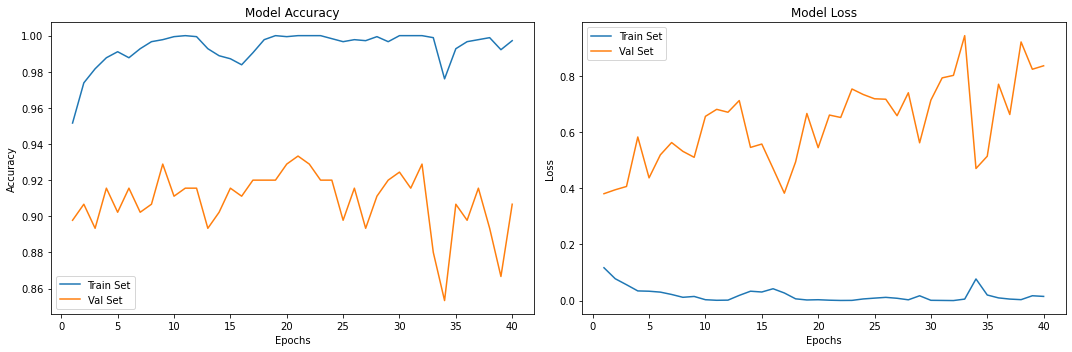

In [32]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
## Cnn skip connection


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Add, Dropout

# Create the model
model_3 = Sequential()

# Layer 1: Convolutional Layer
model_3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(240, 240, 3)))

# Layer 2: Convolutional Layer
model_3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
skip_connection1 = model_3.output

# Layer 3: Max Pooling Layer
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Convolutional Layer
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
skip_connection2 = model_3.output

# Layer 5: Convolutional Layer
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
skip_connection3 = model_3.output

# Layer 6: Max Pooling Layer
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 7: Flatten Layer
model_3.add(Flatten())

# Layer 8: Dense Layer
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.2))

# Layer 9: Skip Connection
model_3.add(Add()([model_3.output, skip_connection3]))

# Layer 10: Dense Layer
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.2))

# Layer 11: Skip Connection
model_3.add(Add()([model_3.output, skip_connection2]))

# Layer 12: Dense Layer
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.2))

# Layer 13: Skip Connection
model_3.add(Add()([model_3.output, skip_connection1]))

# Layer 14: Output Layer
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_3.summary()


ValueError: Inputs have incompatible shapes. Received shapes (120, 120, 64) and (256,)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, Flatten, Dense

# Input layer
input_layer = Input(shape=(240, 240, 3))

# Layer 1
conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Layer 2
conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Layer 3
conv3 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Layer 4
conv4 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(pool3)

# Skip connections
skip1 = Concatenate()([conv3, conv4])
skip2 = Concatenate()([conv2, skip1])
skip3 = Concatenate()([conv1, skip2])

# Flatten layer
flatten = Flatten()(skip3)

# Dropout layer
dropout = Dropout(0.5)(flatten)

# Fully connected layer
fc = Dense(256, activation='relu')(dropout)

# Output layer
output = Dense(1, activation='sigmoid')(fc)

# Create the model
model_4 = Model(inputs=input_layer, outputs=output)

# Print the model summary
model_4.summary()


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 60, 60, 256), (None, 30, 30, 512)]

In [ ]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [87]:
model = build_model(IMG_SHAPE)

In [88]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 244, 244, 3)      0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_2 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [89]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
52/52 [==============================] - 122s 2s/step - loss: 0.8199 - accuracy: 0.6362 - val_loss: 0.6234 - val_accuracy: 0.7053
Epoch 2/50
52/52 [==============================] - 116s 2s/step - loss: 0.4667 - accuracy: 0.7706 - val_loss: 0.5689 - val_accuracy: 0.7536
Epoch 3/50
52/52 [==============================] - 116s 2s/step - loss: 0.4136 - accuracy: 0.8123 - val_loss: 0.6446 - val_accuracy: 0.6135
Epoch 4/50
52/52 [==============================] - 119s 2s/step - loss: 0.3806 - accuracy: 0.8390 - val_loss: 0.4574 - val_accuracy: 0.8068
Epoch 5/50
52/52 [==============================] - 116s 2s/step - loss: 0.3048 - accuracy: 0.8801 - val_loss: 0.5405 - val_accuracy: 0.7150
Epoch 6/50
52/52 [==============================] - 117s 2s/step - loss: 0.2705 - accuracy: 0.8892 - val_loss: 0.5790 - val_accuracy: 0.6860
Epoch 7/50
52/52 [==============================] - 120s 2s/step - loss: 0.2714 - accuracy: 0.8947 - val_loss: 0.3631 - val_accuracy: 0.8647
Epoch 8/50
52

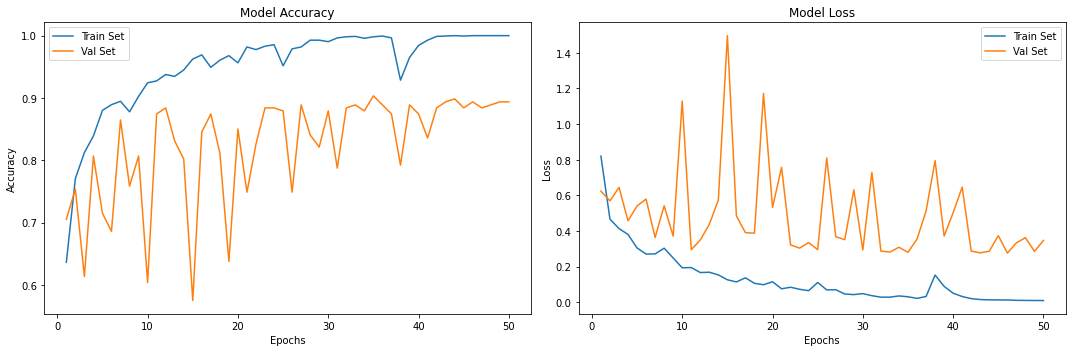

In [91]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()